In [1]:
%matplotlib inline

import math

from matplotlib import pylab
pylab.rcParams['figure.figsize'] = (8.0, 8.0)

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [48]:
from numpy import genfromtxt
train_data = genfromtxt(
    "/Users/mark/Downloads/fashionmnist/fashion-mnist_train.csv", delimiter=',')
test_data = genfromtxt(
    "/Users/mark/Downloads/fashionmnist/fashion-mnist_test.csv", delimiter=',')

In [53]:
# strip col labels
tr_data_arr = train_data[1:-1]
# shuffle data
np.random.shuffle(tr_data_arr)

In [54]:
# get pic labels
tr_labels = tr_data_arr[:,0]

# get pics
tr_ims = tr_data_arr[:,1:]

# strip col labels
te_data_arr = test_data[1:-1]

# get pic labels
te_labels = te_data_arr[:,0]

# get pics
te_ims = te_data_arr[:,1:]

In [55]:
# One-hot encoding
tr_labels_one_hot = np.identity(10)[tr_labels.astype(np.uint8)]
te_labels_one_hot = np.identity(10)[te_labels.astype(np.uint8)]
tr_labels_one_hot.shape

(59999, 10)

In [71]:
# fig = plt.figure()
# n = 36
# for i in range(n):
#     ax = fig.add_subplot(math.sqrt(n), math.sqrt(n), i + 1)
#     ax.set_xticks(())
#     ax.set_yticks(())
#     ax.imshow(tr_ims[i].reshape((28,28)), cmap='Greys_r')  

In [57]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.05)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

In [58]:
x = tf.placeholder(tf.float32, shape=[None, 784])
x_ = tf.reshape(x, [-1, 28, 28, 1]) # batch examples, width, height, num channels
y_ = tf.placeholder(tf.float32, shape=[None, 10])

# Define the first convolution layer here
W_conv1 = weight_variable([12, 12, 1, 25])
b_conv1 = bias_variable([25])
h_conv1 = tf.nn.relu(tf.nn.conv2d(x_, W_conv1, strides=[1, 2, 2, 1], padding='VALID')
                     + b_conv1)

# Define the second convolution layer here
W_conv2 = weight_variable([5,5,25,64])
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(tf.nn.conv2d(h_conv1, W_conv2, strides=[1,1,2,1], padding='SAME') 
                     + b_conv2)

# Define maxpooling
h_pool2 = tf.nn.max_pool(h_conv2, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

# All subsequent layers will be fully connected ignoring geometry so we'll flatten the layer
# Flatten the h_pool2_layer (as it has a multidimensiona shape) 
h_pool2_flat = tf.reshape(h_pool2, [-1, 15*64])

# Define the first fully connected layer here
W_fc1 = weight_variable([15 * 64, 1024])
b_fc1 = bias_variable([1024])
# h_fc1 = 
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

# Use dropout for this layer (should you wish)
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# The final fully connected layer
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

In [59]:
# We'll use the cross entropy loss function 
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_conv, labels=y_))

# And classification accuracy
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# And the Adam optimiser
train_step = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cross_entropy)

In [60]:
class Data(object):
    
    def __init__(self, x_train, y_train):
        self.x_train = x_train.astype(int)
        self.y_train = y_train.astype(int)
        self.cur_idx = 0
        
    def next_batch(self, request_batch_size = 50):
        max_batch_idx = math.ceil(self.x_train.shape[0]/request_batch_size)
        true_idx = self.cur_idx % (max_batch_idx +1)
        final_batch_size = self.x_train.shape[0]%request_batch_size
        idx_1 = request_batch_size * true_idx
        if(true_idx == max_batch_idx):
            idx_2 = idx_1 + final_batch_size
        else:
            idx_2 = idx_1 + request_batch_size
        self.cur_idx += 1
        return [self.x_train[idx_1:idx_2], self.y_train[idx_1:idx_2]]

In [61]:
# keep_prob = 0.5 #dropout
# Start a tf session and run the optimisation algorithm
sess = tf.Session()
sess.run(tf.global_variables_initializer())

data = Data(tr_ims, tr_labels_one_hot)

for i in range(6000):
    batch = data.next_batch(request_batch_size = 50)
    if i % 100 == 0:
        train_accuracy = accuracy.eval(feed_dict={
            x: batch[0], y_: batch[1], keep_prob: 1.0}, session = sess)
        print('Step %d, Training Accuracy %g' % (i, train_accuracy))
    train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5}, session=sess)

print('Test Accuracy %g' % accuracy.eval(feed_dict={
    x: te_ims, y_: te_labels_one_hot, keep_prob: 1.0}, session=sess))

Step 0, Training Accuracy 0.16
Step 100, Training Accuracy 0.82
Step 200, Training Accuracy 0.74
Step 300, Training Accuracy 0.88
Step 400, Training Accuracy 0.78
Step 500, Training Accuracy 0.82
Step 600, Training Accuracy 0.92
Step 700, Training Accuracy 0.8
Step 800, Training Accuracy 0.86
Step 900, Training Accuracy 0.82
Step 1000, Training Accuracy 0.82
Step 1100, Training Accuracy 0.72
Step 1200, Training Accuracy nan
Step 1300, Training Accuracy 0.8
Step 1400, Training Accuracy 0.76
Step 1500, Training Accuracy 0.72
Step 1600, Training Accuracy 0.8
Step 1700, Training Accuracy 0.78
Step 1800, Training Accuracy 0.74
Step 1900, Training Accuracy 0.8
Step 2000, Training Accuracy 0.94
Step 2100, Training Accuracy 0.88
Step 2200, Training Accuracy 0.92
Step 2300, Training Accuracy 0.8
Step 2400, Training Accuracy 0.897959
Step 2500, Training Accuracy 0.88
Step 2600, Training Accuracy 0.9
Step 2700, Training Accuracy 0.84
Step 2800, Training Accuracy 0.8
Step 2900, Training Accuracy 0

In [62]:
label_titles = ["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal", "Shirt",
"Sneaker", "Bag", "Ankle boot"]
# label_titles.reverse()

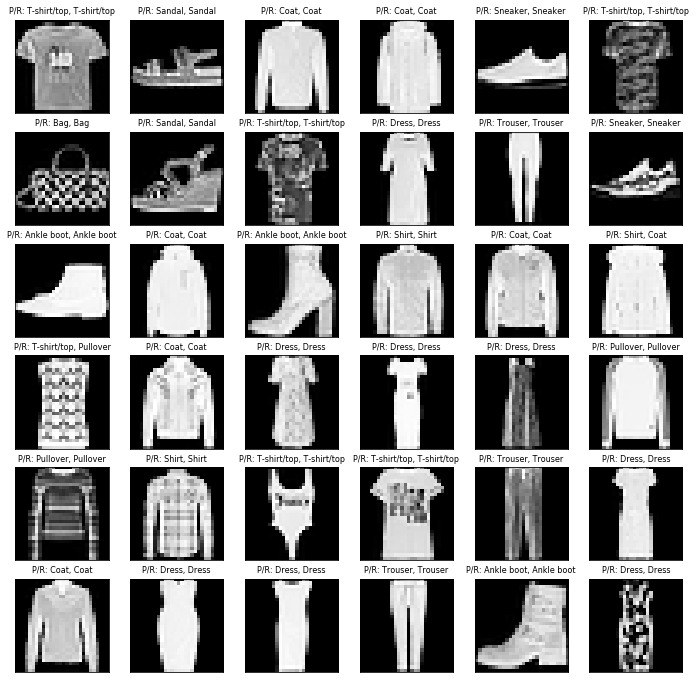

In [70]:
start = 120
n = 36
# end=start+n
predict = tf.argmax(y_conv, 1)
preds = predict.eval(feed_dict={x: te_ims[start:n+start], keep_prob: 1.0}, session=sess)

pylab.rcParams['figure.figsize'] = (12.0, 12.0)
fig = plt.figure()
for i in range(n):
    ax = fig.add_subplot(math.sqrt(n), math.sqrt(n), i + 1)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.imshow(te_ims[start+i].reshape((28,28)), cmap='Greys_r')
    ax.set_title("P/R: " + str(label_titles[int(preds[i])]) + ", " +
                 str(label_titles[int(te_labels[start+i])]), fontsize=8)